<img src="mbit_logo.png" alt="drawing" align="right" style="float" width="150" height="150"/>

<font color="#D31525"><h3 align="left">Detección de fraude en transacciones financieras</h3></font>
<font color="#2C3E50"><h3 align="left"> RED NEURONAL + REDUCCIÓN DE ATRIBUTOS + UNDERSAMPLING </h3></font>

## Importar librerias
En esta primera parte del código, se realizan las llamadas a las librerías que se utilizarán en el Notebook:

In [1]:
# Paquetes de manipulación de datos
import pandas as pd
import numpy as np
import boto3

# Paquetes de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Paquetes para normalizar los resultados
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline      import make_pipeline

# Paquetes para aplicar el modelo: Red neuronal
from sklearn.model_selection import GridSearchCV           # grid de parámetros definido
from sklearn.model_selection import RandomizedSearchCV     # grid de parámetros aleatorios sobre una determinada
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

# Definición de funciones  
A continuación, definimos una función que se encargará de hacer ajuste de parámetros del algoritmo, de acuerdo a los parámetros pasados como argumento, y que mostrará un informe con los resultados obtenidos.

In [2]:
def doGridSearch(model, grid, scores, X_train, y_train, X_test, y_test, columns, indices):
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf=GridSearchCV(model, grid, cv=3, scoring='%s' % score, iid=False)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()

        means=clf.cv_results_['mean_test_score']
        stds =clf.cv_results_['std_test_score']

        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

        conf=pd.DataFrame(
            confusion_matrix(y_test, y_pred),
            columns=columns,
            index  =indices
        )
        print(conf)
        
        return clf.best_estimator_

## Importar DataSets
Importamos los datasets Train-Test y Evaluación para los que se ha aplicado PCA y submuestreo para ajustar la distribución de la clase mayoritaria.

In [3]:
s3 = boto3.client("s3")

# Seleccionamos el bucket con el que vamos a trabajar
BUCKET_NAME = 'tfmfraud'

## TrainTest

In [4]:
# Descargamos el fichero del bucket de s3 a la máquina EC2 para poder trabajar con él.
s3.download_file(Bucket = BUCKET_NAME, Key = 'train_test_over_dis.csv',Filename = '/tmp/train_test_over_dis.csv')

In [5]:
#Leemos el fichero y lo metemos en un dataframe.
trainTestDis = pd.read_csv('/tmp/train_test_over_dis.csv', dtype={'rank':'category'})

In [6]:
print (trainTestDis.shape)

(470000, 9)


In [7]:
trainTestDis.head()

,balanceOrig,balanceDest,newbalanceDest,amount,day,hours_day,type_TRANSFER,newbalanceOrig,isFraud
0,181.0,0.0,0.0,181.0,1,1,1,0.0,1.0
1,181.0,-21182.0,0.0,181.0,1,1,0,0.0,1.0
2,2806.0,0.0,0.0,2806.0,1,1,1,0.0,1.0
3,2806.0,-26202.0,0.0,2806.0,1,1,0,0.0,1.0
4,20128.0,0.0,0.0,20128.0,1,1,1,0.0,1.0


In [8]:
pd.value_counts(trainTestDis['isFraud'])

0.0    420800
1.0     49200
Name: isFraud, dtype: int64

In [9]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/train_test_over_dis.csv

## Evaluacion

In [10]:
# Descargamos el fichero del bucket de s3 a la máquina EC2 para poder trabajar con él.
s3.download_file(Bucket = BUCKET_NAME, Key = 'eval_over_dis.csv',Filename = '/tmp/eval_over_dis.csv')

In [11]:
#Leemos el fichero y lo metemos en un dataframe.
evalDis = pd.read_csv('/tmp/eval_over_dis.csv', dtype={'rank':'category'})

In [12]:
print (evalDis.shape)

(80000, 9)


In [13]:
evalDis.head()

,balanceOrig,balanceDest,newbalanceDest,amount,day,hours_day,type_TRANSFER,newbalanceOrig,isFraud
0,8.318578e+06,8.318578e+06,8.574436e+06,8.318578e+06,9,20,0,0.0,1.0
1,3.207200e+05,3.207200e+05,1.368527e+06,3.207200e+05,29,5,0,0.0,1.0
2,2.480947e+06,0.000000e+00,0.000000e+00,2.480947e+06,6,13,1,0.0,1.0
3,3.607461e+04,0.000000e+00,0.000000e+00,3.607461e+04,8,19,1,0.0,1.0
4,2.727997e+04,0.000000e+00,0.000000e+00,2.727997e+04,18,7,1,0.0,1.0


In [14]:
pd.value_counts(evalDis['isFraud'])

0.0    79200
1.0      800
Name: isFraud, dtype: int64

In [15]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/eval_over_dis.csv

## Red de Neuronas
En este caso, para aplicar una red neuronal, vamos a normalizar los datos para mejorar los resultados:

### Entrenamiento y test del modelo

In [16]:
# Para iniciar con el modelo, separamos en X las variables independientes y en Y la variable dependiente:
y = trainTestDis.loc[:, 'isFraud'].values
X = trainTestDis.drop(columns=['isFraud']).values

In [17]:
# Creamos los conjuntos de entrenamiento y test:
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

# Verificamos los tamaños de los df:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((329000, 8), (141000, 8), (329000,), (141000,))

In [18]:
# Configuramos una red de neuronas
norm =StandardScaler()
mlp=MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(4, 1), random_state=1, verbose=True)
mlpUnderRedDim=make_pipeline(norm, mlp)

In [19]:
# Ajustar el modelo
mlpUnderRedDim.fit(X_train, y_train)

Iteration 1, loss = 0.35251626
Iteration 2, loss = 0.16647548
Iteration 3, loss = 0.10538650
Iteration 4, loss = 0.08259401
Iteration 5, loss = 0.07028146
Iteration 6, loss = 0.06298360
Iteration 7, loss = 0.05790147
Iteration 8, loss = 0.05370689
Iteration 9, loss = 0.05011912
Iteration 10, loss = 0.04698050
Iteration 11, loss = 0.04428888
Iteration 12, loss = 0.04203674
Iteration 13, loss = 0.03992704
Iteration 14, loss = 0.03808407
Iteration 15, loss = 0.03671894
Iteration 16, loss = 0.03546594
Iteration 17, loss = 0.03427172
Iteration 18, loss = 0.03336709
Iteration 19, loss = 0.03243966
Iteration 20, loss = 0.03156472
Iteration 21, loss = 0.03082087
Iteration 22, loss = 0.03007412
Iteration 23, loss = 0.02943265
Iteration 24, loss = 0.02881018
Iteration 25, loss = 0.02816180
Iteration 26, loss = 0.02758732
Iteration 27, loss = 0.02725389
Iteration 28, loss = 0.02676671
Iteration 29, loss = 0.02618670
Iteration 30, loss = 0.02583106
Iteration 31, loss = 0.02543794
Iteration 32, los

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(4, 1),
                               random_state=1, verbose=True))])

In [20]:
# Realizamos la predicción sobre el conjunto de test
mlpUnderRedDim_pred=mlpUnderRedDim.predict(X_test)

print(classification_report(y_test, mlpUnderRedDim_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, mlpUnderRedDim_pred),
    columns=['Precicted No Default', 'Predicted Default'],
    index  =['True No Default'     , 'True Default'     ]
)
print(conf)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    126109
         1.0       0.98      0.98      0.98     14891

    accuracy                           1.00    141000
   macro avg       0.99      0.99      0.99    141000
weighted avg       1.00      1.00      1.00    141000

                 Precicted No Default  Predicted Default
True No Default                125780                329
True Default                      323              14568


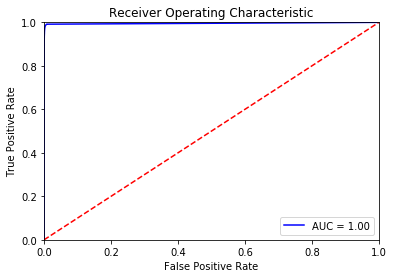

In [21]:
# Área bajo la curva ROC:  
    # Para calcular el área bajo la curva ROC (AUC) es necesario obtener
    # la probabilidad de salida del clasificador con `predict_proba`
prediccion_prob = mlpUnderRedDim.predict_proba(X_test)
#la primera columna corresponde a la etiqueta 'N'
#Es necesario convertir los True Labels a un array lógico (1 para etiqueta N)
roc_auc_score((y_test==0), prediccion_prob[:,0])

probs = mlpUnderRedDim.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Clasificación de nuevos valores 
Aplicamos el modelo al dataframe de evaluación:

In [22]:
# Para iniciar con el modelo, separamos en X las variables independientes y en Y la variable dependiente:
evaly = evalDis.loc[:, 'isFraud'].values
evalX = evalDis.drop(columns=['isFraud']).values

In [23]:
# Aplicamos el modelo
mlpUnderRedDim.score(evalX, evaly)

0.997425

In [24]:
# Calculamos la predicción
predEval = mlpUnderRedDim.predict(evalX)

In [25]:
# Matriz de confusión
cm=confusion_matrix(evaly, predEval)
pd.DataFrame(cm, index=('0_true','1_true'), columns=('0_pred','1_pred'))

,0_pred,1_pred
0_true,79006,194
1_true,12,788


In [26]:
pru = np.where(predEval > 0.4,1,0)
print(classification_report(evaly, pru))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     79200
         1.0       0.80      0.98      0.88       800

    accuracy                           1.00     80000
   macro avg       0.90      0.99      0.94     80000
weighted avg       1.00      1.00      1.00     80000



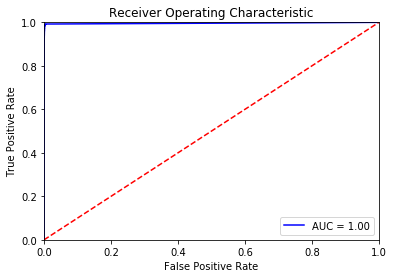

In [27]:
# Curva ROC
probs_eval = mlpUnderRedDim.predict_proba(evalX)
preds_eval = probs_eval[:,1]
fpr_eval, tpr_eval, threshold_eval = metrics.roc_curve(evaly, preds_eval)
roc_auc_eval = metrics.auc(fpr_eval, tpr_eval)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_eval, tpr_eval, 'b', label = 'AUC = %0.2f' % roc_auc_eval)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Guardamos la predicción
Guardamos la predicción realizada en el dataframe de Evaluación:

In [29]:
predNN = pd.DataFrame(predEval, columns = ["NNUnderRedDim_pred"])
modelResult = pd.concat([evalDis, predNN["NNUnderRedDim_pred"]],axis = 1)
modelResult.head()

,balanceOrig,balanceDest,newbalanceDest,amount,day,hours_day,type_TRANSFER,newbalanceOrig,isFraud,NNUnderRedDim_pred
0,8.318578e+06,8.318578e+06,8.574436e+06,8.318578e+06,9,20,0,0.0,1.0,1.0
1,3.207200e+05,3.207200e+05,1.368527e+06,3.207200e+05,29,5,0,0.0,1.0,1.0
2,2.480947e+06,0.000000e+00,0.000000e+00,2.480947e+06,6,13,1,0.0,1.0,1.0
3,3.607461e+04,0.000000e+00,0.000000e+00,3.607461e+04,8,19,1,0.0,1.0,1.0
4,2.727997e+04,0.000000e+00,0.000000e+00,2.727997e+04,18,7,1,0.0,1.0,1.0


In [30]:
pd.crosstab(index=modelResult['isFraud'],columns=modelResult['NNUnderRedDim_pred'], margins=True)

NNUnderRedDim_pred,0.0,1.0,All
isFraud,,,
0.0,79006,194,79200
1.0,12,788,800
All,79018,982,80000


In [31]:
modelResult.to_csv('/tmp/eval_over_dis_pred_rn.csv', index = False)

In [32]:
s3.upload_file(Bucket = BUCKET_NAME, Key = 'eval_over_dis_pred_rn.csv', Filename = '/tmp/eval_over_dis_pred_rn.csv')

In [33]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/eval_over_dis_pred_rn.csv